In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [5]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
redWine_df = pd.read_csv('winequality-red.csv', sep=';')
redWine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
#Get target vector as a separate numpy array and remove target column from dataframe.
#Simplify the problem to binary in which wines are either good (score>7) or bad(score<7)

Y = redWine_df["quality"].values
redWine_df = redWine_df.drop('quality', axis = 1)
Y = np.asarray([1 if i>=7 else 0 for i in Y])
redWine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
print(Y)

[0 0 0 ... 0 0 0]


In [8]:
#Save feature information in dataframe as numpy array
#Plot cross validation scores of random forests as a function of the number of trees in the random forest, ranging from 1 (simple decision tree) to 40 random
#Use 10fold cross validation

X = redWine_df.as_matrix()
scores = []
for val in range(1,41):
    clf = RandomForestClassifier(n_estimators=val)
    validated = model_selection.cross_val_score(clf, X, Y, cv=10)
    scores.append(validated)


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


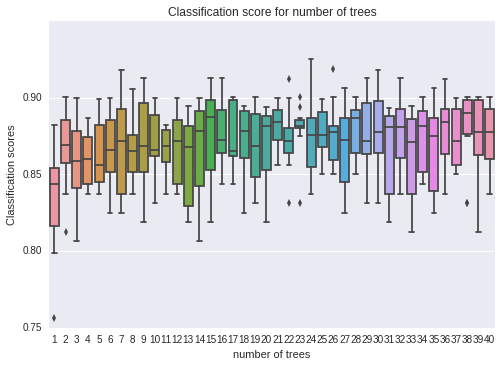

In [9]:
sns.boxplot(range(1,41), scores)
plt.xlabel('number of trees')
plt.ylabel('Classification scores')
plt.title('Classification score for number of trees')
plt.show()

In [10]:
##Evaluating the Unbalanced Class
#In Binary classification problems, accuracy can be misleading if one class(say, bad wine) is much more common than another (say, good wine). This is when the classes are unbalanced.
#Print the percentage of wines that are labeled as bad in the dataset and plot a boxplot, draw a line across the plot denoting the accuracy of always guessing zero.

len_y = len(Y)
temp = [i for i in Y if i==0]
temp_1=temp.count(0)
percentage = float(temp_1)/float(len_y)

In [11]:
print percentage 

0.864290181363


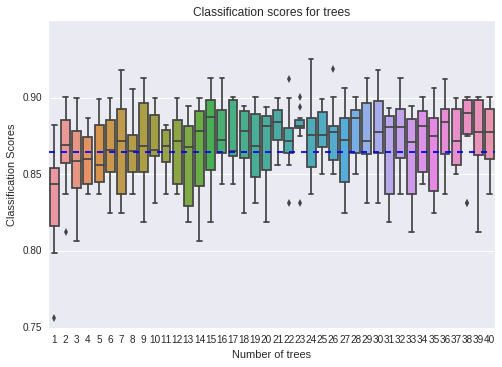

In [12]:
sns.boxplot(range(1,41), scores)
plt.axhline(y = percentage, ls='--')
plt.xlabel('Number of trees')
plt.ylabel('Classification Scores')
plt.title('Classification scores for trees')
plt.show()

In [13]:
#F1 Score is the harmonic mean of recall and precision.
#F1 = (2*recall*precision)/ (recall+precision)
scores = []
for val in range(1,41):
    clf = RandomForestClassifier(n_estimators = val)
    validated = model_selection.cross_val_score(clf, X, Y, cv=10, scoring='f1')
    scores.append(validated)    

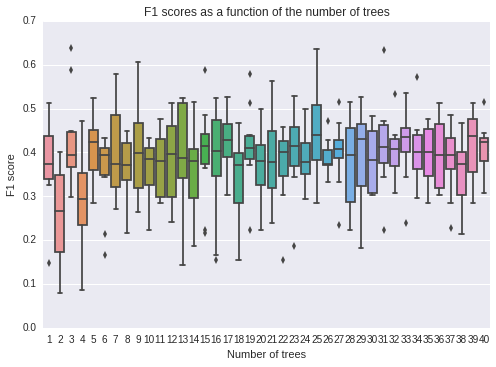

In [14]:
sns.boxplot(range(1,41), scores)
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 scores as a function of the number of trees')
plt.show()

##Scores are clustered around 40% mark

In [15]:
##Setting the cutoff value for prediction
#When the classes in the training data are unbalanced, the prediction probabilities calculated y the classifier can be inaccurate because many classifiers do not know how to adjust for this imbalance.
#This problem is solved using calibration.

In [16]:
##Predict proba function in scikit-learn
#Fit a random forest classifier to wine data using 15trees.
#Compute the predicted probabilities that the classifier assined to each of the training samples using predict_proba method.
#test case - construct prediction based on the predicted probabilities of being in class 1 >0.5  and class 0 otherwise.

clf = RandomForestClassifier(n_estimators =15)
clf.fit(X,Y)
##predict_proba returns 2columns, column1 is class) and column2 is class1
(clf.predict_proba(X)[:,1] > 0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
#Using 10-fold cross validation, find a cutoff in np.arange(0.1,0.9,0.1) that gives the best average F1 score when converting prediction probabilities from a 15-tree random forest classifier into predictions.

def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1]>cutoff).astype(int)

scores = []

def custom_f1(cutoff):
    def f1_cutoff(clf, X, Y):
        ypred = cutoff_predict(clf, X, cutoff)
        return sklearn.metrics.f1_score(Y, ypred)
    return f1_cutoff

for cutoff in np.arange(0.1, 0.9, 0.1):
    clf = RandomForestClassifier(n_estimators=15)
    validated = model_selection.cross_val_score(clf, X, Y, cv=10, scoring = custom_f1(cutoff))
    scores.append(validated)

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


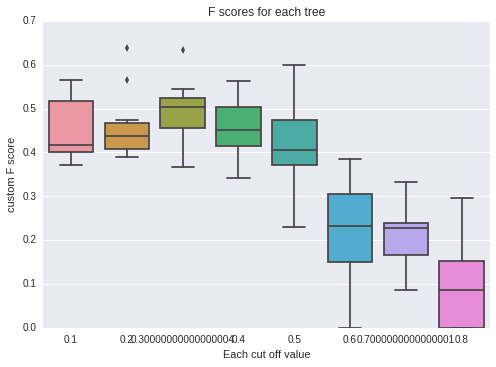

In [18]:
sns.boxplot(np.arange(0.1,0.9,0.1), scores, names=np.arange(0.1,0.9,0.1))
plt.title('F scores for each tree')
plt.xlabel('Each cut off value')
plt.ylabel('custom F score')
plt.show()

In [19]:
##A cut-off of 0.3 to 0.5 appears to give the best predictive performance.

In [24]:
##Visualizing the decision boundary
#A trained classifier takes in X and tries to predict the target Y. We can visualize how the classifier translates different inputs X into a guess for Y by plotting the classifier's prediction probability as a function of features X.

In [25]:
#Use feature_importances_ attribute of the random forest classifier to obtain the relative importance of the features.

(0.0598711992247414, 0.06193200809339626, 0.0675921927352719, 0.07117014625062329, 0.07631948480060571, 0.08142948462918034, 0.08332859359619285, 0.09479793377310736, 0.12175883623736791, 0.12441403356219505, 0.1573860870973179)


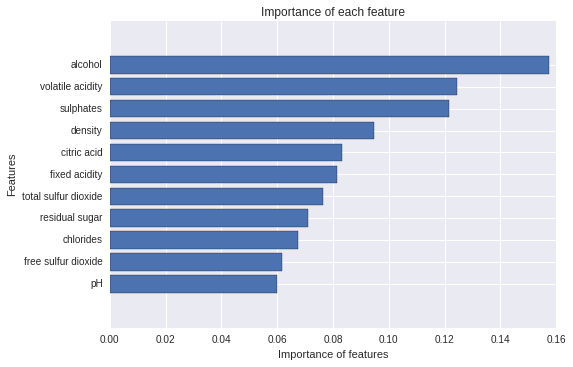

In [37]:
clf = RandomForestClassifier(n_estimators = 15)
clf.fit(X,Y)

imp = clf.feature_importances_
names = redWine_df.columns

imp, names = zip(*sorted(zip(imp,names)))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

In [38]:
##Plot the decision surfaces of a decision tree classifier, and a random forest classifier with number of trees set to 15, and a support vector machine with C set to 100, and gamma set to 1.0.

In [40]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

In [41]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step = 0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columns")
    
    x_min, x_max = X_train[:,0].min() - plot_step, X_train[:,0].max() + plot_step
    y_min, y_max = X_train[:,1].min() - plot_step, X_train[:,1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    clf.fit(X_train, Y_train)
    
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=plt.cm.Paired)
    plt.show()

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


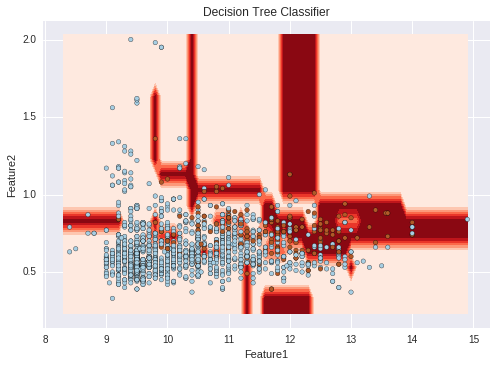

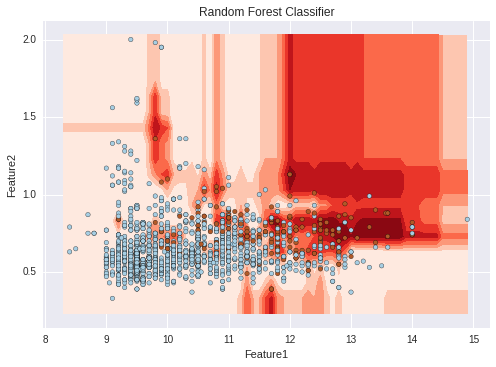

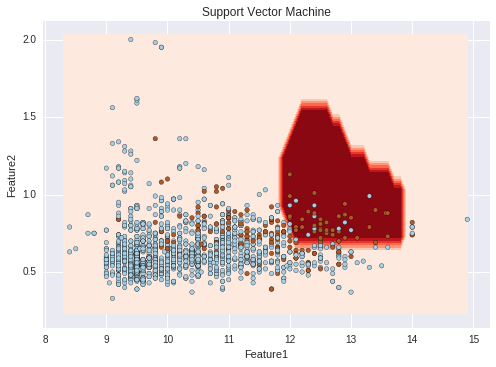

In [43]:
imp_fe = np.argsort(imp)[::-1][0:2]
X_imp = X[:, imp_fe]

algorithms = [DecisionTreeClassifier(), RandomForestClassifier(), sklearn.svm.SVC(C=100.0, gamma=1)]
title = ['Decision Tree Classifier', 'Random Forest Classifier', 'Support Vector Machine']

for i in xrange(3):
    plt.title(title[i])
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plot_decision_surface(algorithms[i], X_imp, Y)

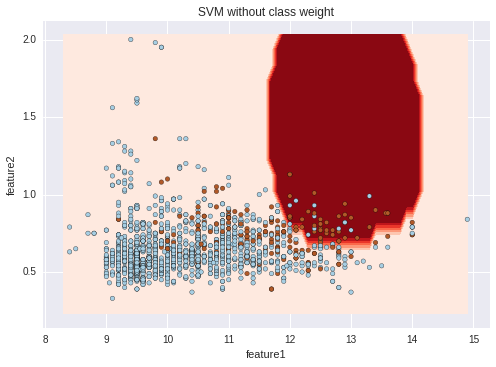

/usr/local/lib/python2.7/dist-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


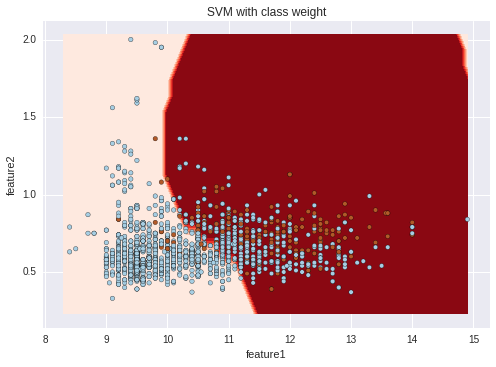

In [47]:
##The SVM implementation of sklearn has an optional parametre class_weight. Default value is None. It also has an auto mode.
#Draw decision boundaries for 2 SVM classifiers. C=1.0, gamma=1.0 , class_weight =None for one, auto for the other.
title = ['SVM without class weight', 'SVM with class weight']
svm = [sklearn.svm.SVC(C=1.0,gamma=1.0, class_weight=None), sklearn.svm.SVC(C=1.0, gamma=1.0, class_weight='auto')]
for i in xrange(2):
    plt.title(title[i])
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plot_decision_surface(svm[i], X_imp, Y)